# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [90]:
import sys
from pathlib import Path
import os

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml


if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Read the API keys and configuration variables from the file <root_dir>/.env
from mlfs import config
if os.path.exists(f"{root_dir}/.env"):
    settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: /home/axel/TMAIM/ID2223/mlfs-book
HopsworksSettings initialized!


In [91]:
import datetime
from datetime import timedelta
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from mlfs.airquality import util

In [92]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2025, 11, 18, 22, 55, 21, 855190)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [93]:
project = hopsworks.login()
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

2025-11-18 22:55:21,869 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-11-18 22:55:21,870 INFO: Initializing external client
2025-11-18 22:55:21,871 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-11-18 22:55:22,505 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2025-11-18 22:55:23,202 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1286302


## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [94]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_lag_xgboost_model",
    version=1,
)

fv = retrieved_model.get_feature_view()

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

2025-11-18 22:55:28,016 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/524850 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/84071 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/26181 elapsed<00:00 remaining<?

In [95]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model_lag.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='2.1163998E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float',
                            'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [96]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)

### Load lagged air quality feature group
air_quality_lag_fg = fs.get_feature_group(
    name='air_quality_lag',
    version=2,
)

batch_data = weather_fg.filter(weather_fg.date >= today).read()

# --- robust: read lag FG into pandas and normalize date to midnight UTC ---
lag_df = air_quality_lag_fg.read()

# Parse any format into timezone-aware UTC timestamps, then normalize to midnight UTC
lag_df["date"] = pd.to_datetime(lag_df["date"], utc=True)      # ensures tz-aware (UTC)
lag_df["date"] = lag_df["date"].dt.tz_convert("UTC").dt.normalize()  # midnight UTC

# Make a UTC midnight timestamp for 'today' to compare with the normalized FG dates
today_utc_midnight = pd.Timestamp.now(tz="UTC").normalize()

# Filter in pandas (works reliably)
today_lag_row = lag_df.loc[lag_df["date"] == today_utc_midnight].copy()


if len(today_lag_row) == 0:
    raise ValueError("No lag values found for today in the lag feature group.")

# Extract scalar lag values
lag1 = float(today_lag_row["pm25_lag_1d"].iloc[0])
lag2 = float(today_lag_row["pm25_lag_2d"].iloc[0])
lag3 = float(today_lag_row["pm25_lag_3d"].iloc[0])

# Attach lag features to every forecast row
batch_data["pm25_lag_1d"] = lag1
batch_data["pm25_lag_2d"] = lag2
batch_data["pm25_lag_3d"] = lag3



Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.73s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.45s) 


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [97]:
feature_cols = [
    'pm25_lag_1d',
    'pm25_lag_2d',
    'pm25_lag_3d',
    'temperature_2m_mean',
    'precipitation_sum',
    'wind_speed_10m_max',
    'wind_direction_10m_dominant'
]

batch_data["pm25_lag_1d"] = batch_data["pm25_lag_1d"].astype(float)
batch_data["pm25_lag_2d"] = batch_data["pm25_lag_2d"].astype(float)
batch_data["pm25_lag_3d"] = batch_data["pm25_lag_3d"].astype(float)

batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(
    batch_data[feature_cols]
)

In [98]:
#batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(
#    batch_data[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])
#batch_data

In [99]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         6 non-null      datetime64[us, Etc/UTC]
 1   temperature_2m_mean          6 non-null      float32                
 2   precipitation_sum            6 non-null      float32                
 3   wind_speed_10m_max           6 non-null      float32                
 4   wind_direction_10m_dominant  6 non-null      float32                
 5   city                         6 non-null      object                 
 6   pm25_lag_1d                  6 non-null      float64                
 7   pm25_lag_2d                  6 non-null      float64                
 8   pm25_lag_3d                  6 non-null      float64                
 9   predicted_pm25               6 non-null      float32                
dtypes: dat

### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [100]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data = batch_data.sort_values(by=['date'])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_lag_1d,pm25_lag_2d,pm25_lag_3d,predicted_pm25,street,country,days_before_forecast_day
0,2025-11-19 00:00:00+00:00,-4.70,0.0,5.937272,345.963715,Sundsvall,15.0,22.0,20.0,19.268747,Köpmansgatan,Sweden,1
5,2025-11-20 00:00:00+00:00,-3.30,0.0,10.829958,338.552185,Sundsvall,15.0,22.0,20.0,18.400299,Köpmansgatan,Sweden,6
3,2025-11-21 00:00:00+00:00,-4.05,0.0,7.491114,305.217682,Sundsvall,15.0,22.0,20.0,19.859867,Köpmansgatan,Sweden,4
1,2025-11-22 00:00:00+00:00,2.95,0.0,15.745627,259.460876,Sundsvall,15.0,22.0,20.0,18.655321,Köpmansgatan,Sweden,2
4,2025-11-23 00:00:00+00:00,1.60,0.0,6.638072,220.601212,Sundsvall,15.0,22.0,20.0,15.644946,Köpmansgatan,Sweden,5
2,2025-11-24 00:00:00+00:00,-0.80,0.0,9.387651,302.471161,Sundsvall,15.0,22.0,20.0,16.883663,Köpmansgatan,Sweden,3


In [101]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6 entries, 0 to 2
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         6 non-null      datetime64[us, Etc/UTC]
 1   temperature_2m_mean          6 non-null      float32                
 2   precipitation_sum            6 non-null      float32                
 3   wind_speed_10m_max           6 non-null      float32                
 4   wind_direction_10m_dominant  6 non-null      float32                
 5   city                         6 non-null      object                 
 6   pm25_lag_1d                  6 non-null      float64                
 7   pm25_lag_2d                  6 non-null      float64                
 8   pm25_lag_3d                  6 non-null      float64                
 9   predicted_pm25               6 non-null      float32                
 10  street     

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

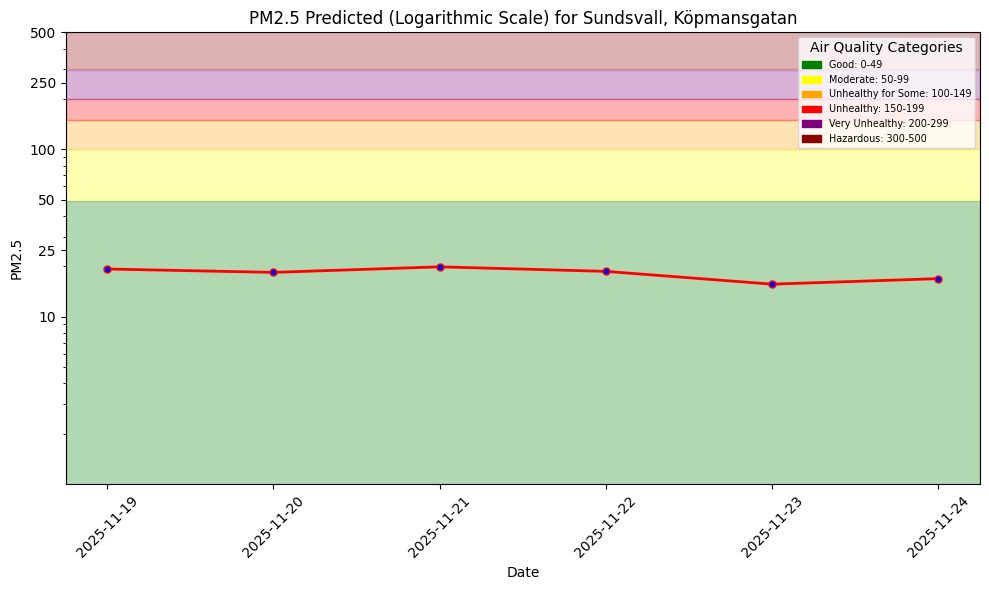

In [102]:

pred_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_forecast.png"
plt = util.plot_air_quality_forecast(city, street, batch_data, pred_file_path)

plt.show()

In [103]:
# Get or create feature group
monitor_fg_lag = fs.get_or_create_feature_group(
    name='aq_predictions_lag',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [104]:
monitor_fg_lag.insert(batch_data, wait=True)

Uploading Dataframe: 100.00% |██████████| Rows 6/6 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_lag_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1286302/jobs/named/aq_predictions_lag_1_offline_fg_materialization/executions
2025-11-18 22:55:58,286 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-18 22:56:04,827 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-18 22:57:43,542 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-18 22:57:43,747 INFO: Waiting for log aggregation to finish.
2025-11-18 22:57:52,468 INFO: Execution finished successfully.


(Job('aq_predictions_lag_1_offline_fg_materialization', 'SPARK'), None)

In [105]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg_lag.filter(monitor_fg_lag.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.58s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_lag_1d,pm25_lag_2d,pm25_lag_3d,predicted_pm25,street,country,days_before_forecast_day
0,2025-11-19 00:00:00+00:00,-4.7,0.0,5.937272,345.963715,Sundsvall,15.0,22.0,20.0,19.268747,Köpmansgatan,Sweden,1


In [106]:
air_quality_lag_fg = fs.get_feature_group(name='air_quality_lag', version=2)
air_quality_df = air_quality_lag_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.32s) 


,date,pm25,pm25_lag_1d,pm25_lag_2d,pm25_lag_3d,country,city,street,url
0,2018-11-13 00:00:00+00:00,28.0,31.0,27.0,34.0,Sweden,Sundsvall,Köpmansgatan,https://api.waqi.info/feed/@9328
1,2018-04-02 00:00:00+00:00,30.0,27.0,24.0,24.0,Sweden,Sundsvall,Köpmansgatan,https://api.waqi.info/feed/@9328
2,2020-11-21 00:00:00+00:00,17.0,6.0,10.0,18.0,Sweden,Sundsvall,Köpmansgatan,https://api.waqi.info/feed/@9328
3,2025-04-08 00:00:00+00:00,12.0,8.0,13.0,18.0,Sweden,Sundsvall,Köpmansgatan,https://api.waqi.info/feed/@9328
4,2022-12-10 00:00:00+00:00,13.0,12.0,19.0,9.0,Sweden,Sundsvall,Köpmansgatan,https://api.waqi.info/feed/@9328
...,...,...,...,...,...,...,...,...,...
2351,2023-11-26 00:00:00+00:00,6.0,12.0,5.0,6.0,Sweden,Sundsvall,Köpmansgatan,https://api.waqi.info/feed/@9328
2352,2025-09-12 00:00:00+00:00,48.0,53.0,33.0,29.0,Sweden,Sundsvall,Köpmansgatan,https://api.waqi.info/feed/@9328
2353,2025-10-11 00:00:00+00:00,12.0,13.0,13.0,20.0,Sweden,Sundsvall,Köpmansgatan,https://api.waqi.info/feed/@9328
2354,2021-03-11 00:00:00+00:00,24.0,16.0,25.0,18.0,Sweden,Sundsvall,Köpmansgatan,https://api.waqi.info/feed/@9328


In [107]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]

# Normalize date formats to avoid error on merge
preds_df["date"] = pd.to_datetime(preds_df["date"]).dt.tz_localize(None).dt.date
outcome_df["date"] = pd.to_datetime(outcome_df["date"]).dt.tz_localize(None).dt.date

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
#if len(hindcast_df) == 0:
#    hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
hindcast_df

2025-11-18 22:57:57,481 WARNING: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

2025-11-18 22:57:57,484 WARNING: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,date,predicted_pm25,pm25


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

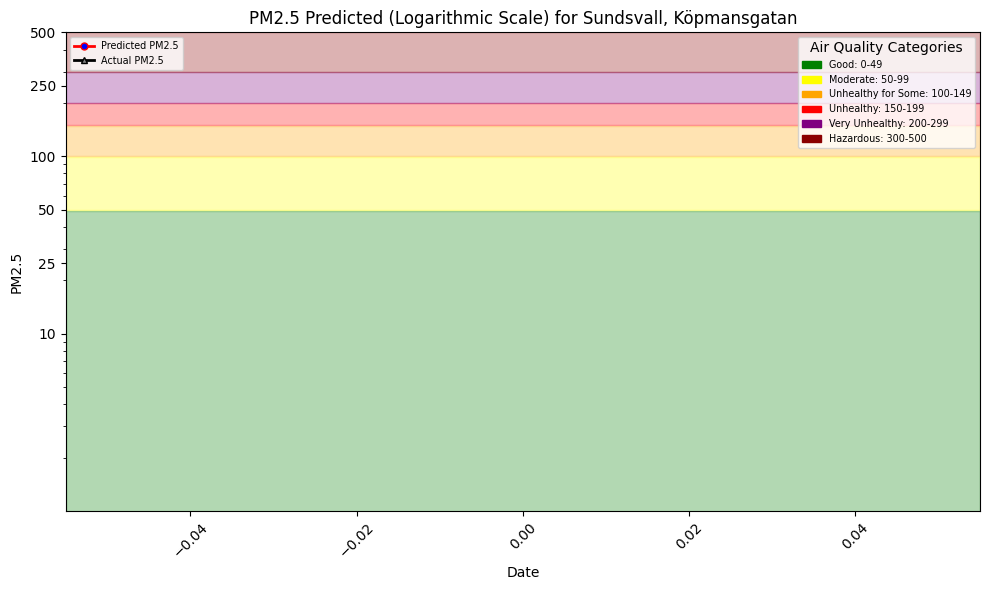

In [108]:
hindcast_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_hindcast_1day.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, hindcast_file_path, hindcast=True)
plt.show()

### Upload the prediction and hindcast dashboards (png files) to Hopsworks


In [109]:
dataset_api = project.get_dataset_api()
str_today = today.strftime("%Y-%m-%d")
if dataset_api.exists("Resources/airquality") == False:
    dataset_api.mkdir("Resources/airquality")
dataset_api.upload(pred_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)
dataset_api.upload(hindcast_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)

proj_url = project.get_url()
print(f"See images in Hopsworks here: {proj_url}/settings/fb/path/Resources/airquality")

Uploading /home/axel/TMAIM/ID2223/mlfs-book/docs/air-quality/assets/img/pm25_forecast.png: 0.000%|          | …

Uploading /home/axel/TMAIM/ID2223/mlfs-book/docs/air-quality/assets/img/pm25_hindcast_1day.png: 0.000%|       …

See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1286302/settings/fb/path/Resources/airquality


---